# Report : Lab Model Monitoring (delayed flight)

Git Repository : https://github.com/LeMarechalDeFer/MLOps_CPE393-LabModelMonitoring

Our check with Evidently shows the model behaves very differently once we move from Jan-Jun (reference) to Jul-Dec (current).

Data drift: only the Month column drifted (which is normal—we split the year in two). All other 29 columns look the same, so the feature space itself is stable.

Model quality: numbers get worse. MAE jumps from 0.9 min to 2.4 min and RMSE from 3.9 min to 10.6 min. The dummy baseline now matches the model, meaning our forest brings no real gain in summer/autumn. R² is still high (0.995 → 0.971) but the big max error (613 min) shows it struggles with outliers.

Take-away: the model trained on the first half-year doesn’t transfer well to the second half. We should retrain regularly or add season-related features (weather, holidays, airport load) before using it in production.

### Quality Report

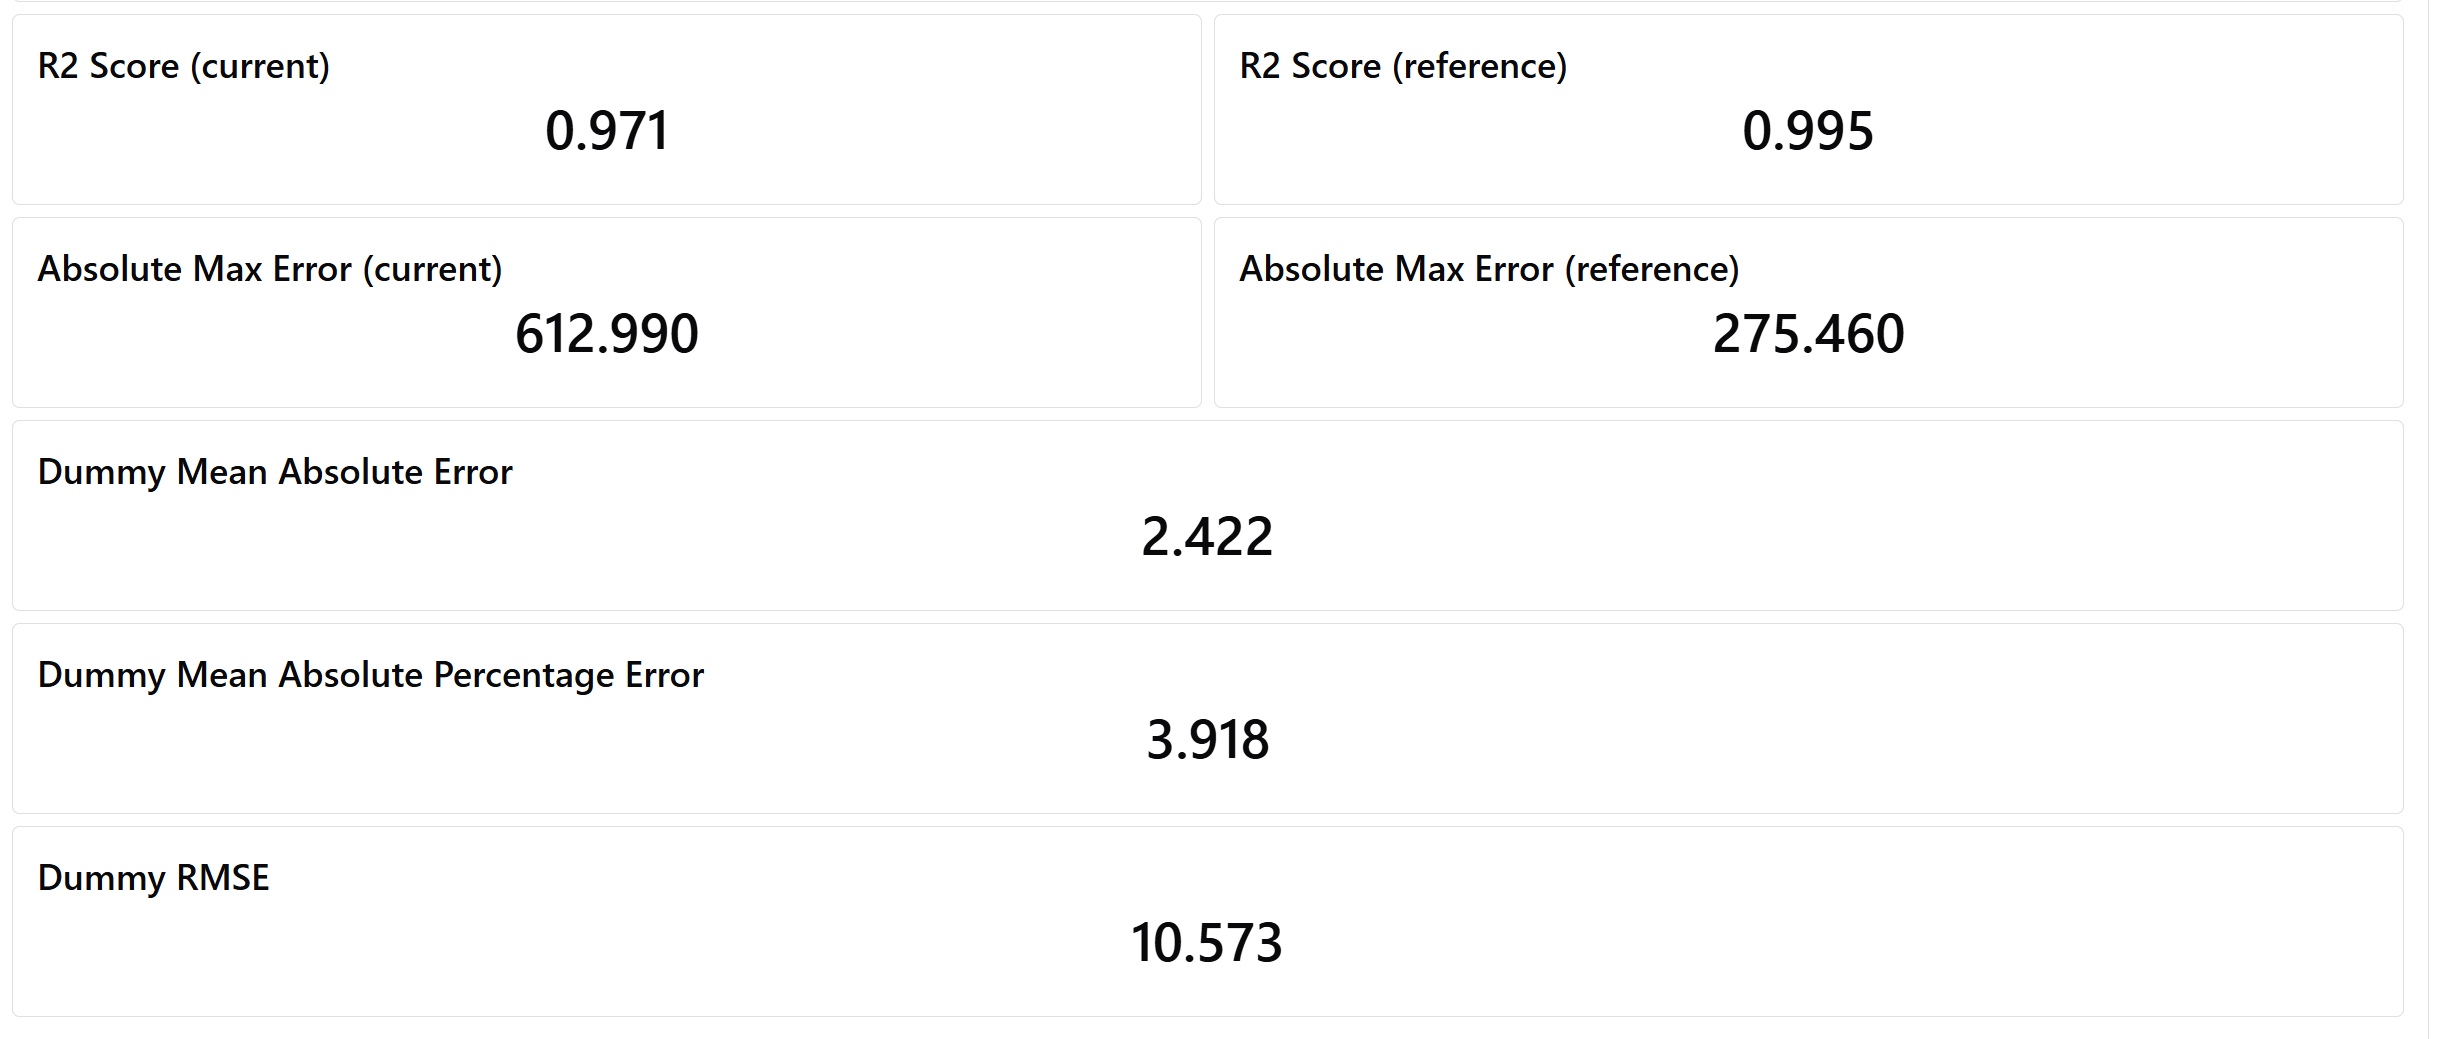

In [5]:
from IPython.display import Image

Image("images/quality_report.png")


### Data Set Drift

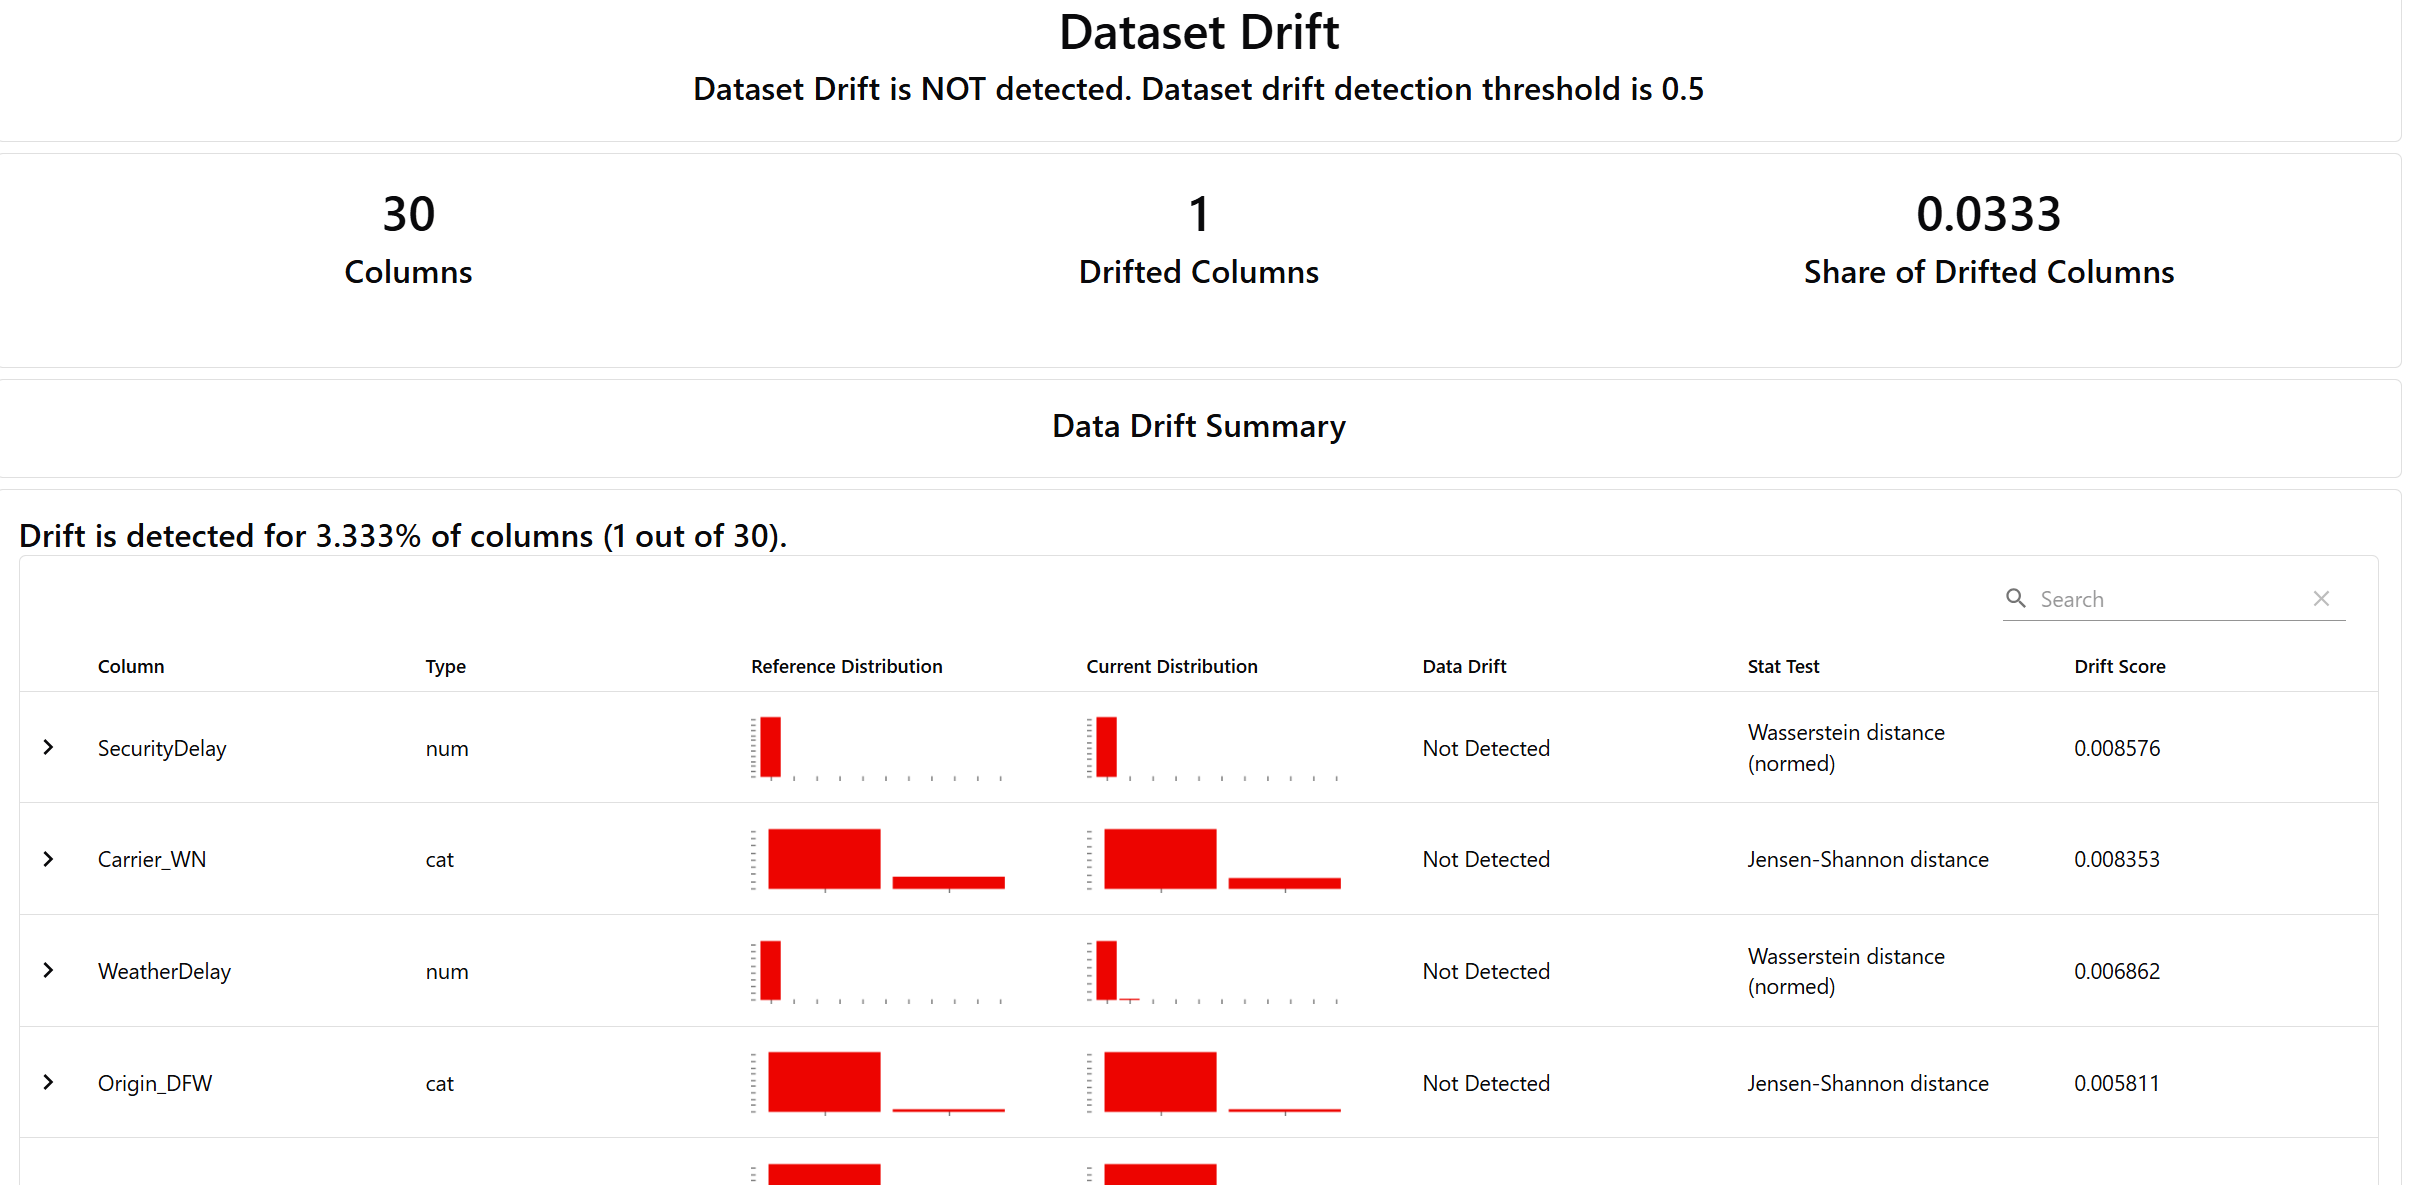

In [6]:
Image("images/dataset_drift.png")


In [ ]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor

from evidently import Report, DataDefinition, Regression, Dataset
from evidently.metrics import (
    MeanError, MAE, MAPE, RMSE, R2Score,
    AbsMaxError, DummyMAE, DummyMAPE, DummyRMSE
)
from evidently.presets import DataDriftPreset

# 1) Loading
df = pd.read_csv("DelayedFlights.csv")

# 2) Basic filtering
df = df[df["Cancelled"] == 0].copy()

# 3) Feature engineering
# 3.1 Extract scheduled departure time
df["CRSDepHour"] = (df["CRSDepTime"].fillna(0).astype(int) // 100).clip(0,23)
# 3.2 Difference between announced vs actual flight time
df["DelayDiff"] = df["ActualElapsedTime"] - df["CRSElapsedTime"]
# 3.3 Total taxi time
df["TaxiTotal"] = df["TaxiIn"] + df["TaxiOut"]
# 3.4 Reduced categorical variables
top_carriers = df["UniqueCarrier"].value_counts().nlargest(5).index
df["CarrierGroup"] = df["UniqueCarrier"].where(df["UniqueCarrier"].isin(top_carriers), "Other")
car_dummies = pd.get_dummies(df["CarrierGroup"], prefix="Carrier")

top_origins = df["Origin"].value_counts().nlargest(10).index
df["OriginGroup"] = df["Origin"].where(df["Origin"].isin(top_origins), "Other")
orig_dummies = pd.get_dummies(df["OriginGroup"], prefix="Origin")

# 3.5 Concatenate and clean
df = pd.concat([df, car_dummies, orig_dummies], axis=1)

# 4) Selection of useful columns + removal of NaN
base_features = [
    "Month", "DayOfWeek", "Distance",
    "CarrierDelay", "WeatherDelay", "NASDelay",
    "SecurityDelay", "LateAircraftDelay",
    "CRSDepHour", "DelayDiff", "TaxiTotal"
]
dummy_features = list(car_dummies.columns) + list(orig_dummies.columns)
all_features = base_features + dummy_features
df_filtered = df[all_features + ["DepDelay"]].dropna()

# 5) Creation of reference / current datasets (months 1-6 vs 7-12)
# We take 20,000 samples if available, otherwise half of the dataset
N = min(20000, df_filtered.shape[0]//2)
reference_data = df_filtered[df_filtered["Month"] <= 6].sample(N, random_state=42)
current_data   = df_filtered[df_filtered["Month"] >  6].sample(N, random_state=42)

# 6) Model training
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(reference_data[all_features], reference_data["DepDelay"])

# 7) Predictions
reference_data["prediction"] = model.predict(reference_data[all_features])
current_data["prediction"]   = model.predict(current_data[all_features])

# 8) Data drift report
drift_report = Report(metrics=[DataDriftPreset()])
drift_snapshot = drift_report.run(
    reference_data=reference_data,
    current_data=current_data
)
drift_snapshot.save_html("data_drift_report.html")
print("Data drift report generated: data_drift_report.html")
drift_snapshot

# 9) Model quality report
# 9.1 Target/prediction definition
data_definition = DataDefinition(
    regression=[Regression(target="DepDelay", prediction="prediction")]
)
ref_ds = Dataset.from_pandas(reference_data, data_definition=data_definition)
cur_ds = Dataset.from_pandas(current_data,   data_definition=data_definition)

# 9.2 Choice of metrics
regression_report = Report(metrics=[
    MeanError(), MAE(), MAPE(), RMSE(), R2Score(),
    AbsMaxError(), DummyMAE(), DummyMAPE(), DummyRMSE()
])
quality_snapshot = regression_report.run(
    reference_data=ref_ds,
    current_data=cur_ds
)
quality_snapshot.save_html("model_quality_report.html")
print("Model quality report generated: model_quality_report.html")
quality_snapshot





Data drift report generated: data_drift_report.html


/home/talleyrand/anaconda3/envs/machineLearning/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning:

R^2 score is not well-defined with less than two samples.

/home/talleyrand/anaconda3/envs/machineLearning/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning:

R^2 score is not well-defined with less than two samples.

/home/talleyrand/anaconda3/envs/machineLearning/lib/python3.10/site-packages/sklearn/metrics/_regression.py:1266: UndefinedMetricWarning:

R^2 score is not well-defined with less than two samples.



Model quality report generated: model_quality_report.html
